<a href="https://www.kaggle.com/code/harishlakshman/cs5661-project?scriptVersionId=239015640" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install pytorch-lightning
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import pytorch_lightning as pl #to speed up execution
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from tqdm import tqdm

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2) #check if we have GPU's or multiple CPU cores

AVAIL_GPUS = min(1, torch.cuda.device_count())
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishalkundar/gandata20")

print("Path to dataset files:", path)
trainingDataPath = path + '/birds/train/64images.pickle'
testindDataPath = path + '/birds/test/64images.pickle'
print("Path to training dataset files:", trainingDataPath)
print("Path to testing dataset files:", testindDataPath)

/kaggle/input/gandata20/birds/test/char-CNN-RNN-embeddings.pickle
/kaggle/input/gandata20/birds/test/64images.pickle
/kaggle/input/gandata20/birds/test/256images.pickle
/kaggle/input/gandata20/birds/train/char-CNN-RNN-embeddings.pickle
/kaggle/input/gandata20/birds/train/64images.pickle
/kaggle/input/gandata20/birds/train/256images.pickle
Path to dataset files: /kaggle/input/gandata20
Path to training dataset files: /kaggle/input/gandata20/birds/train/64images.pickle
Path to testing dataset files: /kaggle/input/gandata20/birds/test/64images.pickle


In [101]:
import pickle

# Sample data
data = {'a': 1, 'b': [2, 3, 4], 'c': 'hello'}

# Pickling (serializing) and saving to a file
with open('data.pickle', 'wb') as file:
    pickle.dump(data, file)

# Unpickling (deserializing) from a file
with open('data.pickle', 'rb') as file:
    loaded_data = pickle.load(file)

print(loaded_data)

{'a': 1, 'b': [2, 3, 4], 'c': 'hello'}


In [102]:
def displaySingleImage(X_train, y_train):
    plt.imshow(X_train[0], cmap="gray")
    plt.title(f"Label: {y_train[0]}")

In [103]:
def check_type(variable):
    if isinstance(variable, np.ndarray):
        return "NumPy array"
    elif isinstance(variable, pd.DataFrame):
        return "Pandas DataFrame"
    else:
        return "Neither NumPy array nor Pandas DataFrame"

In [104]:
# "/kaggle/input/gandata20/birds/train/64images.pickle"
with open(trainingDataPath, "rb") as file:
    low_res_Xtrain = pickle.load(file)
file.close()    
print(low_res_Xtrain[0])    

[[[147 138 110]
  [169 159 142]
  [174 164 149]
  ...
  [156 144 126]
  [145 133 115]
  [154 149 135]]

 [[111 100  57]
  [111 103  59]
  [129 118  82]
  ...
  [135 126  90]
  [130 124  89]
  [128 118  94]]

 [[115 106  63]
  [117 102  63]
  [141 129 101]
  ...
  [139 131 101]
  [145 135 111]
  [139 130 117]]

 ...

 [[122 110  76]
  [132 122  82]
  [143 133  99]
  ...
  [149 142 125]
  [147 138 125]
  [147 140 121]]

 [[169 152 141]
  [134 119  99]
  [160 153 126]
  ...
  [149 139 128]
  [122 112  94]
  [121 113  81]]

 [[151 142 125]
  [156 145 134]
  [151 136 126]
  ...
  [121 111  91]
  [112  95  70]
  [103  89  57]]]


In [105]:
   
#print(low_res_ytrain[0])
# Try loading with latin1 encoding
try:
    with open("/kaggle/input/gandata20/birds/train/char-CNN-RNN-embeddings.pickle", 'rb') as f:
        low_res_ytrain = pickle.load(f, encoding='latin1')
except UnicodeDecodeError:
    # If latin1 fails, try bytes encoding
    with open("/kaggle/input/gandata20/birds/train/char-CNN-RNN-embeddings.pickle", 'rb') as f:
        low_res_ytrain = pickle.load(f, encoding='bytes')
        # Depending on the data structure, you might need to decode the keys and values
        # Example:
        # data = {k.decode('utf-8'): v.decode('utf-8') for k, v in data.items()}
f.close()   

print(low_res_ytrain[0])


[[-0.1984601   0.06850037 -0.08754172 ... -0.04081321 -0.0404707
  -0.23237257]
 [-0.04099498  0.09040367  0.06530468 ... -0.02985617 -0.05980737
  -0.12394436]
 [-0.03710739  0.24822547  0.17509311 ... -0.09786586 -0.08509018
  -0.09630494]
 ...
 [-0.20583372  0.20465058  0.13165587 ... -0.01983263 -0.04040046
  -0.07836005]
 [ 0.30727547  0.11746128  0.05263393 ... -0.07507791 -0.01925883
  -0.14054832]
 [-0.10245901  0.08354798 -0.05507605 ... -0.07359622 -0.05397442
  -0.00404962]]


In [106]:
print(len(low_res_Xtrain))
print(len(low_res_ytrain))

8855
8855


In [107]:
type(low_res_Xtrain)

list

In [108]:
low_res_ytrain_np = np.array(low_res_ytrain)
low_res_ytrain_np.shape

(8855, 10, 1024)

In [109]:
first_image = low_res_ytrain_np[0]
first_caption_embedding = first_image[0]
print("First image, first caption embedding: ", first_caption_embedding)
low_res_ytrain_np_flat = low_res_ytrain_np.reshape(8855,-1)
df = pd.DataFrame(low_res_ytrain_np_flat)
df.head(5)

First image, first caption embedding:  [-0.1984601   0.06850037 -0.08754172 ... -0.04081321 -0.0404707
 -0.23237257]


,0,1,2,3,4,5,6,7,8,9,...,10230,10231,10232,10233,10234,10235,10236,10237,10238,10239
0,-0.198460,0.068500,-0.087542,0.207038,-0.081768,-0.025190,-0.064414,0.079852,-0.126337,0.101191,...,0.101164,-0.042420,-0.276217,-0.020168,-0.046126,0.044658,0.034102,-0.073596,-0.053974,-0.004050
1,-0.138480,0.102934,0.112115,0.040127,-0.153174,-0.135386,-0.039163,-0.021358,-0.019029,0.167204,...,-0.003404,-0.124328,-0.249514,0.018295,-0.174079,0.117695,-0.085069,-0.038967,-0.071250,0.232506
2,0.055297,0.022587,0.403976,0.260986,0.003611,-0.081628,-0.322527,-0.024476,-0.057909,0.239709,...,0.249615,-0.032500,-0.088891,0.164370,-0.046237,0.153161,-0.038780,-0.012908,-0.046202,0.065019
3,-0.008370,0.071405,-0.049069,-0.013646,0.152964,-0.067452,0.085614,-0.010297,-0.001601,0.038742,...,0.139085,0.079119,-0.242593,-0.202783,-0.115970,-0.117501,0.159037,0.069533,-0.060734,0.028022
4,-0.022361,-0.025681,0.474252,0.103380,0.096887,-0.124234,-0.361739,-0.077656,0.001753,0.238186,...,0.231952,-0.029053,-0.303358,-0.135626,-0.108568,-0.040371,0.025763,0.072154,-0.052367,0.095333


In [110]:
low_res_Xtrain_np = np.array(low_res_Xtrain)
low_res_Xtrain_np.shape

(8855, 64, 64, 3)

In [111]:
print('64images type : ', check_type(low_res_Xtrain))
print('length of list: ', len(low_res_Xtrain))

64images type :  Neither NumPy array nor Pandas DataFrame
length of list:  8855


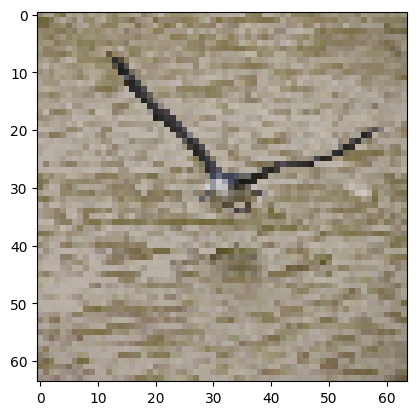

In [112]:
plt.imshow(low_res_Xtrain[0], cmap="gray")

## Download the datset

## split the data into training & validation

## Create a class that inherits from Pytorch lightning data module.
## Responsible for creating data loaders for training, validation & test set

In [113]:
class PickleImageDataset(Dataset):
    def __init__(self, pickle_path, transform=None):
        with open(pickle_path, 'rb') as f:
            self.images = pickle.load(f)
        self.images = [img for img in self.images if img is not None]
        self.transform = transform


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        #convert to tensor if not already
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).float() / 255.0
            if img.shape[-1] == 3:
                img = img.permute(2,0,1)
            #img = torch.tensor(img, dtype=torch.float32).permute(2,0,1) / 255.0
            #img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        if self.transform:
            img = self.transform(img)
        return img

class BIRDSDataModule(pl.LightningDataModule):
    def __init__(
        self,
        pickle_path_train,
        pickle_path_test,
        batch_size: int = BATCH_SIZE,
        val_split=0.2,
        num_workers: int = NUM_WORKERS
    ):
        super().__init__()
        self.pickle_path_train = pickle_path_train
        self.pickle_path_test =  pickle_path_test #initalize class data with dataset
        self.batch_size = batch_size #initalize class data batch size
        self.val_split = val_split
        self.num_workers = num_workers #assigns cpu cores

        #defines class tranformation methods
        #Tensors are similar to NumPy arrays, but tensors have accelerator support. 
        #Tensors are optimized for automatic differentiation.
        """
        self.transform = transforms.Compose(
            [
                #transforms.Resize((224,224)), # img_size=224 is a convention rooted in ImageNet-pretrained models. Safe default or standard
                #transforms.ToTensor(), transforms images to tensors.
                transforms.Normalize(mean=[0.4234, 0.4927, 0.4830], std=[0.1923, 0.1815, 0.1827]) #tranformed data is normalized. Ex: 0.1307 = mean; 0.3081 = std deviation
            ]
        )
        """
        self.transform = transforms.Normalize(mean=[0.4234, 0.4927, 0.4830], std=[0.1923, 0.1815, 0.1827])
        self.dims = (1, 28, 28)
        self.num_classes = 10

        #def prepare_data(self):
        # download
        #MNIST(self.data_dir, train=True, download=True) #download training data
        #MNIST(self.data_dir, train=False, download=True)#download testing data

    # Assign train/val datasets for use in dataloaders
    def setup(self, stage=None):
        
        if stage == "fit" or stage is None:
            # Assign train/val datasets for use in dataloaders
            dataset = PickleImageDataset(self.pickle_path_train, transform=self.transform)
            val_size = int(len(dataset) * self.val_split)
            train_size = len(dataset) - val_size
            self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])
            
        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            dataset = PickleImageDataset(self.pickle_path_test, transform=self.transform)
            val_size = 0
            test_size = len(dataset) - val_size
            self.test_dataset, x = random_split(dataset, [test_size, val_size])

    #Training
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )
    #Validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    #Testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [114]:
def get_mean_std(pickle_path, batch_size=64, img_size=224):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

    #dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataset = PickleImageDataset(pickle_path)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
    mean = 0
    std = 0
    total_images_count = 0

    for images in tqdm(loader):
        if images is None:
            continue
        #images = batch[0] if isinstance(batch, (list, tuple)) else batch # support both (data, labels) & data only
        batch_samples = images.size(0) # batch size (number of images)
        images = images.view(batch_samples, images.size(1), -1) #[B, C, H*W]
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples
    mean /= total_images_count
    std /= total_images_count
    return mean, std

In [115]:
mean, std = get_mean_std(trainingDataPath)
print("mean is: ", mean)
print("std dev is: ", std)


100%|██████████| 139/139 [00:01<00:00, 107.18it/s]

mean is:  tensor([0.4234, 0.4927, 0.4830])
std dev is:  tensor([0.1923, 0.1815, 0.1827])


### BUILD THE GENERATOR
#### Generate fake data from random noise

In [116]:
"""
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)
"""

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 4 -> 8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 8 -> 16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 16 -> 32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 32 -> 64
            nn.Tanh()  # final activation for output in [-1, 1]
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        x = self.deconv_layers(x)
        return x


### BUILD THE DISCRIMINATOR
#### Distinguish between real and fake data

In [117]:
"""
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)# 1 = grayscale or channels in input image, 10 filters of size(5,5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)
"""



class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1),  # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc = nn.Linear(512 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 512 * 4 * 4)
        x = self.fc(x)
        return x  # raw logits — use BCEWithLogitsLoss for training


In [118]:
#TODO: GAN
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        #random noise 6 images
        self.validation_z = torch.randn(6, self.hparams.latent_dim)
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        y_hat = torch.sigmoid(y_hat)
        return F.binary_cross_entropy(y_hat, y)
    """
    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        # sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)
        opt_g, opt_d = self.optimizers()
        #train generator: max log(D(G(z)))
        #if optimizer_idx == 0:
        fake_imgs = self(z) #generator generates fake images
        y_hat = self.discriminator(fake_imgs) #model prediction by discriminator of fake images

        y = torch.ones(real_imgs.size(0), 1)
        y = y.type_as(real_imgs) # move to gpu
        g_loss = self.adversarial_loss(y_hat, y)
        log_dict = {"g_loss": g_loss}
        #return {"gloss": g_loss, "progress_bar": log_dict, "log": log_dict}

        #train discriminator: max log (D(x) + log(1 - D(G(z))))
        #if optimizer_idx == 1:
        # how well can it label as real
        y_hat_real = self.discriminator(real_imgs) #model prediction by discriminator of real images
        y_real = torch.ones(real_imgs.size(0), 1) #initialize tensors of unity of size equal to batch size (number of images-->.size(0))
        y_real = y_real.type_as(real_imgs) # move to gpu
        real_loss = self.adversarial_loss(y_hat_real, y_hat)
        # how well can it label as fake
        y_hat_fake = self.discriminator(self(z).detach()) #model prediction by discriminator of fake images. self(z) generates fake images
        #.detach() will create a new tensor which is detached from computational graph
        y_fake = torch.zeros(real_imgs.size(0), 1) #initialize tensors of zero of size equal to batch size (number of images-->.size(0))to implement 1 - D(G(z)))
        y_fake = y_fake.type_as(real_imgs) # move to gpu
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
        d_loss = (real_loss + fake_loss) / 2

        log_dict = {"d_loss": d_loss}
        return {"dloss": d_loss, "progress_bar": log_dict, "log": log_dict}
    """
    def training_step(self, batch, batch_idx):
        #print(f"Batch content: {type(batch)}, {len(batch)}")
        #print(batch)
        #real_imgs, _ = batch
        real_imgs = batch
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim, device=self.device)
        opt_g, opt_d = self.optimizers()
    
        # === Train Generator ===
        fake_imgs = self(z)
        y_hat_fake = self.discriminator(fake_imgs)
        valid = torch.ones(real_imgs.size(0), 1, device=self.device)
        g_loss = self.adversarial_loss(y_hat_fake, valid)
    
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
    
        # === Train Discriminator ===
        y_hat_real = self.discriminator(real_imgs)
        real_loss = self.adversarial_loss(y_hat_real, valid)
    
        fake_imgs_detached = fake_imgs.detach()
        y_hat_fake_detached = self.discriminator(fake_imgs_detached)
        fake = torch.zeros(real_imgs.size(0), 1, device=self.device)
        fake_loss = self.adversarial_loss(y_hat_fake_detached, fake)
    
        d_loss = (real_loss + fake_loss) / 2
    
        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
    
        # Logging
        self.log("g_loss", g_loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("d_loss", d_loss, prog_bar=True, on_step=True, on_epoch=True)



    
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    """
    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()
        print('epoch', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
            #plt.imshow(np.transpose(sample_imgs.detach()[i].cpu().numpy(), (1, 2, 0)))
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()
    """
    def plot_imgs(self):
        z = self.validation_z.to(self.device)
        sample_imgs = self(z).cpu()
        print('epoch', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            # Assuming RGB images:
            img_np = np.transpose(sample_imgs.detach()[i].numpy(), (1, 2, 0))
            plt.imshow(img_np)
            plt.title("Generated Data")
            plt.axis('off')
        plt.show()

    def on_epoch_end(self):
        self.plot_imgs()

epoch 0


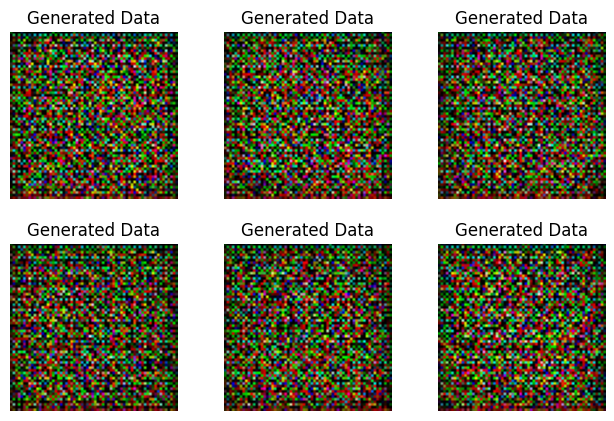

In [119]:
dm = BIRDSDataModule(trainingDataPath, testindDataPath)
model = GAN()
model.plot_imgs()

In [120]:
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Training: |          | 0/? [00:00<?, ?it/s]

### 